In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.optimize import minimize

In [2]:
kernels = {
    'linear': lambda x, y: np.dot(x.T, y),
    'squared_exponential': lambda x, y: 1.95 * np.exp(-1.02 * np.dot((x - y).T, (x - y))),
    'periodic': lambda x, y: np.exp(-np.sin(5 * np.pi * (x - y)) ** 2)
}

In [3]:
# Choose kernel
k = kernels['squared_exponential']

In [4]:
# Choose points at which to sample
x = np.arange(-5, 5, 0.005)
n = len(x)

In [5]:
# Build Covariance matrix
C = np.zeros((n , n))
for i in range(n):
    for j in range(n):
        C[i, j] = k(x[i], x[j])

In [6]:
# Factorise the covariance matrix
U, s, V = np.linalg.svd(C)

In [7]:
# Sample from the GP at sample points (assuming our Gaussian prior has zero mean and covariance C)
u = np.random.randn(n, 1)
z = np.dot(U, np.dot(np.sqrt(np.diag(s)), u))

In [8]:
%%capture
fig, ax = plt.subplots()

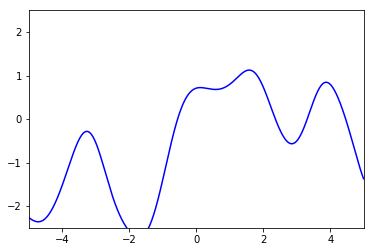

In [9]:
# Plot prior
ax.plot(x, z, 'b')
ax.set_xlim(-5, 5)
ax.set_ylim(-2.5, 2.5)
fig

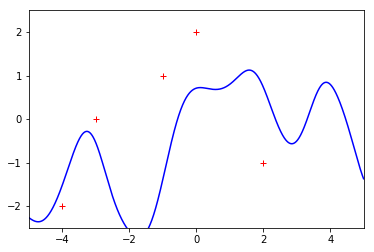

In [10]:
# Plot observations
obs = np.array([[-4, -2], [-3, 0], [-1, 1], [0, 2], [2, -1]])
n_obs = len(obs)
ax.plot(obs[:, 0], obs[:, 1], 'r+')
fig

In [11]:
# Build covariance matrix between observations and sample points, and between observations and themselves
C_so = np.zeros((n, n_obs))
for i in range(n):
    for j in range(n_obs):
        C_so[i, j] = k(x[i], obs[j][0])
C_oo = np.zeros((n_obs, n_obs))
for i in range(n_obs):
    for j in range(n_obs):
        C_oo[i, j] = k(obs[i][0], obs[j][0])

In [12]:
C_oo.shape, C_so.shape, C.shape

((5, 5), (2000, 5), (2000, 2000))

In [13]:
# Calculate predictive mean and variance of posterior distribution
C_oo_inv = np.linalg.inv(C_oo)
predictive_mean = np.dot(C_so, np.dot(C_oo_inv, obs[:, 1]))  # naive implementation (but inverse exists since C_oo has positive pivots - think about the echelon form)
predictive_variance = C - np.dot(C_so, np.dot(C_oo_inv, C_so.T))
predictive_variance = predictive_variance.clip(min=0)

In [15]:
# Check posterior goes through observations with zero variance (our observations were noise free)
predictive_mean[200], predictive_variance[200, 200]  # should be -2 and 0

(-2.0000000000000133, 0.0)

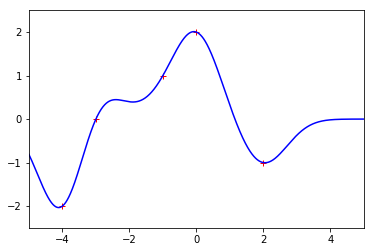

In [16]:
# remove prior function from figure and replace with posterior predictive mean
del ax.lines[0]
ax.plot(x, predictive_mean, 'b')
fig

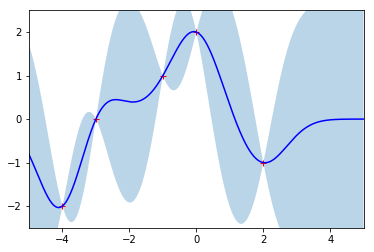

In [17]:
# compute 95% confidence interval from pointwise variances and plot
pointwise_variances = predictive_variance.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)
ax.fill_between(x, predictive_mean - error, predictive_mean + error, alpha=0.3)
fig

In [19]:
def kernel(x, y, amp, alpha):
    return amp * np.exp(-alpha * np.dot((x - y).T, (x - y)))

In [20]:
def K(theta, obs):
    K = np.zeros((n_obs, n_obs))
    for i in range(n_obs):
        for j in range(n_obs):
            K[i, j] = kernel(obs[i][0], obs[j][0], theta[0], theta[1])
    return K

In [21]:
def L(theta, obs):
    n_obs = len(obs)
    C_oo = K(theta, obs)
    C_oo_inv = np.linalg.inv(C_oo)
    L = 0.5 * np.dot(obs[:, 1].T, np.dot(C_oo_inv, obs[:, 1])) + 0.5 * np.log(np.abs(np.linalg.det(C_oo))) + n_obs*np.log(2*np.pi)/2
    return L

In [22]:
theta0 = [1, 5]
solution = minimize(L, theta0, args=(obs), method='BFGS')

/usr/local/lib/python3.5/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.5/site-packages/scipy/optimize/optimize.py:643: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.5/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [23]:
solution

      fun: 8.622986506746477
 hess_inv: array([[ 1.54789262, -0.34345509],
       [-0.34345509,  1.66729694]])
      jac: array([ -2.74181366e-06,  -8.34465027e-07])
  message: 'Optimization terminated successfully.'
     nfev: 125
      nit: 16
     njev: 29
   status: 0
  success: True
        x: array([ 1.94781536,  1.02387052])